# Практическое задание к уроку 6

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Датасет LFW

In [2]:
ds, info= tfds.load('lfw', split='train',shuffle_files=True,
    as_supervised=True,with_info=True)

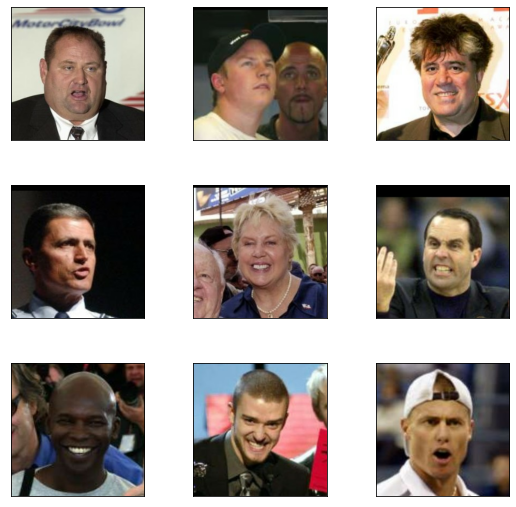

In [3]:
fig = tfds.show_examples(ds, info)

In [4]:
info.features['label']

Text(shape=(), dtype=tf.string)

In [5]:
df=tfds.as_dataframe(ds,info) 
dict_label=df['label'].value_counts().reset_index()
num_class=dict_label.shape[0]
num_class

5749

In [6]:
df['class']=0
for i in range(0, len(df)):
    df.loc[i,'class']=dict_label[dict_label['index']==df['label'][i]].index.values[0]

In [6]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'label': (), 'image': (250, 250, 3)}
{'label': tf.string, 'image': tf.uint8}
(250, 250, 3)
<dtype: 'uint8'>


In [7]:
#### первые 50 классов

In [7]:
num_class=50
train_df=df[df['label'].isin(dict_label[:num_class]['index'])]
train_df.shape

(2773, 3)

In [40]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image'],train_df['class']))

In [33]:
BATCH_SIZE = 10

def normalize_img(image,label):
  """Normalizes images: `uint8` -> `float32`."""
 # print(dict_label['index']==label)
  #print(dict_label['index'])
  return tf.image.resize(tf.cast(image, tf.float32) / 255.,[128,128]),label 

ds_train = train_ds.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [42]:
EMB_SIZE = 50

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [14]:
#model.load_weights('w_Cl_Lesson_6') 

In [43]:
MARGIN = 10.0

def contastive_loss(embs, labels):
   # print(embs,labels)
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
   
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]
    #print(labels1,labels2)
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [44]:
NUM_EPOCHS =50
train_ds = ds_train.repeat(NUM_EPOCHS)


In [45]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [154]:
%%time

for iteration, ( images,labels) in enumerate(train_ds):
   
    # Forward
    with tf.GradientTape() as tape:
        
        embs = model(images)
       
        loss_value = contastive_loss(embs, labels)
       
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        if loss_value.numpy()!=0:
            print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 0.11247167736291885
[200] Loss: 0.004637714475393295
[400] Loss: 0.43588289618492126
[600] Loss: 1.2068625688552856
[800] Loss: 1.0576685667037964
[1000] Loss: 5.629473686218262
[1200] Loss: 1.2629287242889404
[1400] Loss: 0.16491878032684326
[1600] Loss: 0.02529602125287056
[1800] Loss: 30.607120513916016
[2000] Loss: 1.6741735935211182
[2200] Loss: 1.7522729635238647
[2400] Loss: 2.807727336883545
[2800] Loss: 1.1857658624649048
[3000] Loss: 0.2231496125459671
[3400] Loss: 2.3285489082336426
[3600] Loss: 0.849496066570282
[4000] Loss: 3.838304042816162
[4800] Loss: 11.41747760772705
[5400] Loss: 0.03661255165934563
[5600] Loss: 2.1718735694885254
[5800] Loss: 0.005302931182086468
[6000] Loss: 3.901386260986328
[6200] Loss: 1.7718662023544312
[6400] Loss: 5.733396053314209
[6600] Loss: 1.9688549041748047
[6800] Loss: 2.6260783672332764
[7000] Loss: 0.3182745575904846
[7200] Loss: 0.08392197638750076
[7400] Loss: 2.4572031497955322
[7600] Loss: 0.7485944628715515
[7800] Loss:

#### Распределение embedings

In [155]:
emb=[]
lab=[]
for iteration, ( images,labels) in enumerate(train_ds.take(100)):
    for i in range(BATCH_SIZE):
        sample = images[i]
        emb.append(model.predict(sample[None,...])[0])
        lab.append(labels[i])

In [156]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = emb[0]
emb2 = emb[1]
emb3 = emb[2]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  4.548914501112077
A2 <-> B1:  12.89477561018839
A1 <-> B1:  14.265512689522303


In [157]:
test_embs_2D = TSNE(n_components=2).fit_transform(emb)
labels_for_viz = lab

In [158]:
import matplotlib.cm as cm

In [159]:
colors = (cm.rainbow(np.linspace(0, 1, 50)))

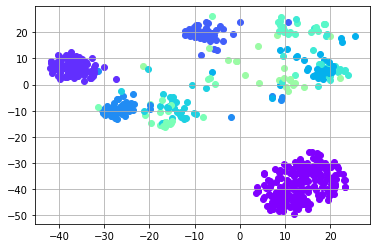

In [160]:
leg=[]
for i in range(len(test_embs_2D)):
    
    if lab[i] in range(0,10):
        plt.scatter(test_embs_2D[i][0],test_embs_2D[i][1],color=colors[lab[i].numpy()*3])
        leg.append(dict_label['index'][lab[i].numpy()])

plt.grid(True)    

### проверка на стороннем изображении

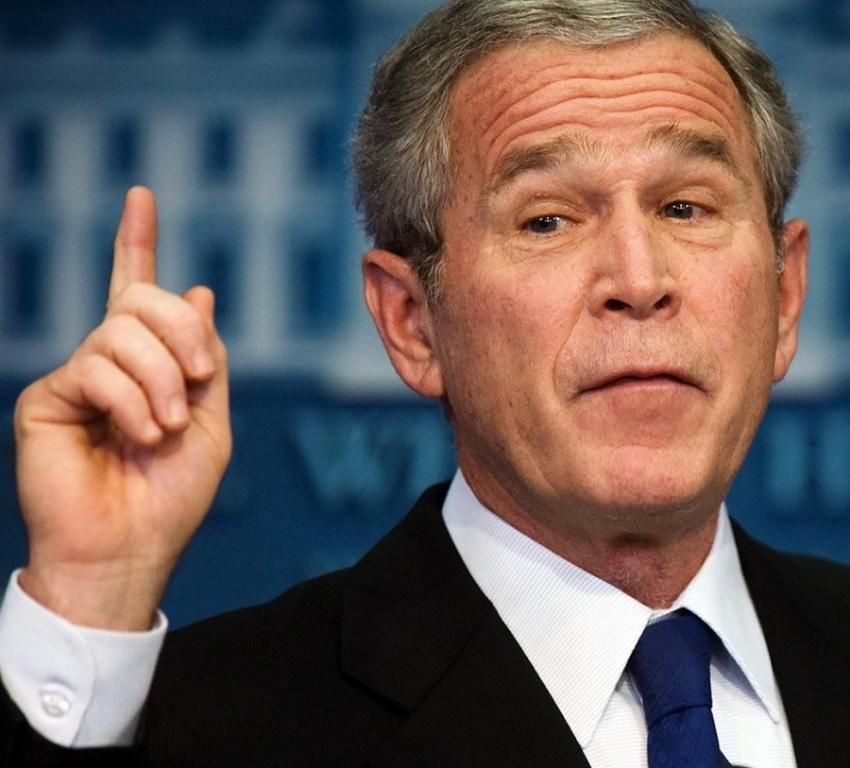

In [161]:
test_image=tf.keras.preprocessing.image.load_img('test.jpg')
test_image

In [162]:
test_image=tf.keras.preprocessing.image.img_to_array(test_image)
test_image=tf.image.resize(tf.cast(test_image, tf.float32) / 255.,[128,128])

In [163]:
test_emb=model.predict(test_image[None,...])

In [164]:
embd_class0=[]
embd_class1=[]
embd_class2=[]
for i in lab:
    if lab[i].numpy()==0:
        embd_class0.append(emb[i])
    elif lab[i].numpy()==1:
        embd_class1.append(emb[i])
    elif lab[i].numpy()==2:
        embd_class2.append(emb[i])    
    

In [165]:
mt=[]
l_class=0
for i in [embd_class0, embd_class1, embd_class2]:
    for embeding in i:
        mt.append(diff(embeding, test_emb))
    print(f'{dict_label["index"][l_class]} <-> J Bush: {np.mean(mt)}')
    l_class+=1

b'George_W_Bush' <-> J Bush: 6.732289084448974
b'Colin_Powell' <-> J Bush: 12.436011033082172
b'Tony_Blair' <-> J Bush: 12.424905165046948


In [166]:
model.save_weights('w_Cl_Lesson_6')
